# Map projections

**Credit:**

[Vuokko Heikinheimo, Henrikki Tenkanen](https://automating-gis-processes.github.io/)  
Department of Geosciences & Geography, University of Helsinki  


## Map projections

**A map projection** (or a projected coordinate system) is a systematic transformation of the latitudes and longitudes into a plain surface where units are quite commonly represented as meters (instead of decimal degrees). This transformation is used to **represent the three dimensional earth on a flat, two dimensional map**.

Most common projections are:
* planar
* cylindrical
* conical

<img src="img/projection_families.png" alt="drawing" width="400"/>  


Map projections are never fully accurate. The results always show some **distortions**. The distortions affect:
* angular conformity
* distance
* area

The choice of projection is always a compromise between those elements. 

The projections that maintain correct properties are called:
* **conformal** or **ortomorphic** => for angular conformity
* **equidistant** or **ortomorphic** => for constant scale
* **equal area**

Let's take a look at [**sample projections**](https://docs.qgis.org/3.16/en/docs/gentle_gis_introduction/coordinate_reference_systems.html)


<img src="img/distortions.jpg" alt="drawing" width="300px"/>


Choosing an appropriate projection for your map is not always straightforward because it depends on what you actually want to represent with your map, and what is the spatial scale of your data. In fact, there is not a single "perfect projection" since each one of them has some strengths and weaknesses, and you should choose a projection that fits best for your needs. In fact, the projection you choose might even tell something about you!
    
![](img/Map-projections.png)

*Source: XKCD, See a full comic about ["What your favorite map projection tells about you"](https://xkcd.com/977/)*.

For those of you who want a bit more analytical approach for choosing the projection, you can get a good overview from [georeference.org](http://www.georeference.org/doc/guide_to_selecting_map_projections.htm), or from this post introducing [the strengths and weaknesses of a few commonly used projections](http://www.geo.hunter.cuny.edu/~jochen/gtech201/lectures/lec6concepts/map%20coordinate%20systems/how%20to%20choose%20a%20projection.htm).

## Coordinate reference systems (CRS)

Coordinate reference systems allow you to describe every place on earth with a set of three numbers, called **coordinaes**.

**CRS** are important because the geometric shapes in a GeoDataFrame are simply a collection of coordinates in an arbitrary space. A CRS tells Python how those coordinates are related to places on the Earth. 

As the CRS in different spatial datasets differ fairly often (i.e. one might have coordinates defined in decimal degrees while the other one has them in meters), it is a common procedure to **reproject** (transform) different layers into a common CRS. It is important that the layers are in the same coordinate reference system when analyzing the spatial relationships between the layers, for example, when making a Point in Polygon -query, or other type of overlay analysis.

Two common CRS systems are:
* **Geographic Coordinate System**, e.g. WGS84
* **Projected Coordinate System**, e.g. UTM

<img src="img/crs.png" alt="drawing" width="500px"/>
A projected coordinate system (PCS) is a GCS that has been flattened using a map projection.

*Source: ESRI ["Geographic vs Projected Coordinate Systems"](https://www.esri.com/arcgis-blog/products/arcgis-pro/mapping/gcs_vs_pcs/)*.

To better understand how CRS work, take a look [here](https://www.earthdatascience.org/courses/earth-analytics/spatial-data-r/intro-to-coordinate-reference-systems/) or [here](https://docs.qgis.org/3.16/en/docs/gentle_gis_introduction/coordinate_reference_systems.html).

## Coordinate reference system (CRS) in Geopandas

Luckily, defining and changing projections is easy using Geopandas and a library called [pyproj](https://pyproj4.github.io/pyproj/stable/). In this tutorial we will see **how to retrieve the
coordinate reference system information from the data, and how to re-project the data into another crs**. We will re-project a data file from
WGS84 (lat, lon coordinates) into a Lambert Azimuthal Equal Area projection.

![](img/projection.gif)

For this tutorial we will be using a Shapefile called `Europe_borders.shp` representing the country borders in Europe. You will find it in `data/Europe_borders` folder. 

In Shapefiles, information about the coordinate reference system is stored in the `.prj` -file. If this file is missing, you might be in trouble! When reading the data into `GeoDataFrame` with Geopandas crs information is automatically stored into the `.crs` attribute of the GeoDataFrame.

Let's start by reading the data from the `Europe_borders.shp` file and checking the `crs`:

In [3]:
# Import geopandas and os packages
import geopandas as gpd
import os


# Read the file
path = ['..', 'data', 'Europe_borders']
file = 'Europe_borders.shp'
fp = os.path.join(*path, file)

data = gpd.read_file(fp)

In [4]:
# Check the coordinate reference system
print(data.crs)
data.crs

epsg:4326


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

What we see here is in fact a CRS object from the pyproj module. 

The EPSG number (named after the *European Petroleum Survey Group*) is a code that tells about the coordinate system of the dataset. "[EPSG Geodetic Parameter Dataset](http://www.epsg.org/) is a collection of definitions of coordinate reference systems and coordinate transformations which may be global, regional, national or local in application".

The EPSG code of our geodataframe is`4326`, which refers to the WGS84 coordinate system (we can also figure this out by looking at the coordinates values which are longitude and latitudes decimal degrees).

You can find a lot of information and lists of available coordinate reference systems from:

  - [www.spatialreference.org](http://spatialreference.org/)
  - [www.proj4.org](https://proj4.org/operations/projections/)
  - [www.mapref.org](http://mapref.org/CollectionofCRSinEurope.html)

- Let's continue by checking the values in our `geometry` -column to verify that the CRS of our GeoDataFrame seems correct:

In [5]:
data.geometry.head()

0    POLYGON ((8.45778 54.56236, 8.44953 54.56269, ...
1    POLYGON ((8.71992 47.69664, 8.72092 47.69530, ...
2    POLYGON ((6.73317 53.57409, 6.73017 53.57542, ...
3    POLYGON ((6.85822 53.59411, 6.85592 53.59550, ...
4    POLYGON ((6.89894 53.62561, 6.88439 53.62814, ...
Name: geometry, dtype: geometry

As we can see, the coordinate values of the Polygons indeed look like latitude and longitude values, so everything seems to be in order.

WGS84 projection is not really a good one for representing European borders on a map (areas get distorted), so let's convert those geometries into Lambert Azimuthal Equal Area projection ([EPSG: 3035](http://spatialreference.org/ref/epsg/etrs89-etrs-laea/)) which is the recommended projection by European Comission.

Changing the projection is simple to [do in Geopandas](http://geopandas.org/projections.html#re-projecting) with `.to_crs()` -function which is a built-in function of the GeoDataFrame. The function has two alternative parameters 1) `crs` and 2) `epgs` that can be used to make the coordinate transformation and re-project the data into the CRS that you want to use. 

- Let's re-project our data into `EPSG 3035` using `epsg` -parameter:

In [6]:
# Let's make a backup copy of our data
data_wgs84 = data.copy()

# Reproject the data
data = data.to_crs(epsg=3035)

In [7]:
# Check the new geometry values
data.geometry.head()

0    POLYGON ((4221214.558 3496203.404, 4220681.651...
1    POLYGON ((4224860.478 2732279.320, 4224932.819...
2    POLYGON ((4104652.176 3390034.953, 4104460.401...
3    POLYGON ((4113025.664 3391895.756, 4112879.943...
4    POLYGON ((4115871.228 3395282.099, 4114921.348...
Name: geometry, dtype: geometry

And here we go, the coordinate values in the geometries have changed! Now we have successfully changed the projection of our layer into a new one, i.e. to `Lambert Azimuthal Equal Area` projection. 

To really understand what is going on, it is good to explore our data visually. Let's compare the datasets by making
maps out of them.


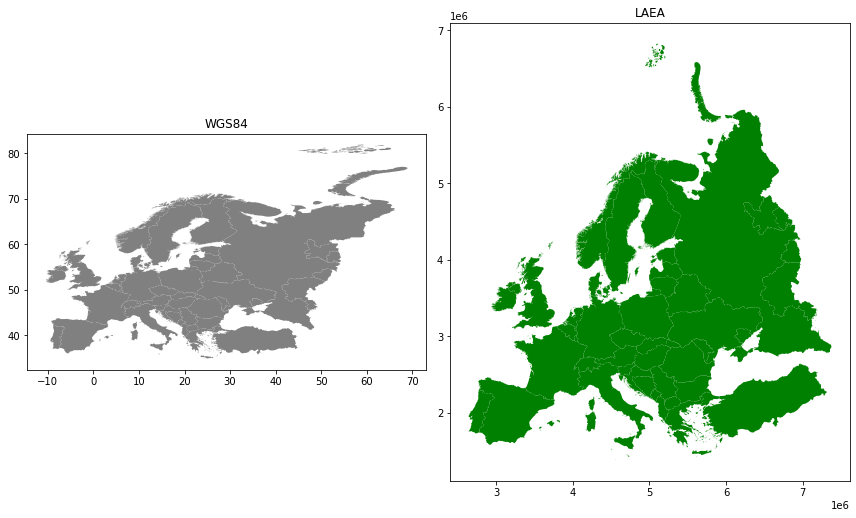

In [10]:
# import matplotlib
import matplotlib.pyplot as plt


# Make subplots that are next to each other
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))


# Plot the data in WGS84 CRS
data_wgs84.plot(ax=ax1, facecolor='gray')

# Add title
ax1.set_title('WGS84')

# Plot the one with ETRS-LAEA projection
data.plot(ax=ax2, facecolor='green')

# Add title
ax2.set_title('LAEA')

# Set aspect ratio as 1
ax1.set_aspect(aspect=1)
ax2.set_aspect(aspect=1)

# Remove empty white space around the plot
plt.tight_layout()

Indeed, the maps look quite different, and the re-projected one looks much better in Europe as the areas especially in the north are more realistic and not so stretched as in WGS84.

Finally, let's save our projected layer into a Shapefile so that we can use it later. Note, even if the crs information is stored in the .prj file, it might be a good idea also to include crs info in the filename:

In [11]:
# Ouput filepath
path = ['..', 'data', 'Europe_borders']
outfile = 'Europe_borders_epsg3035.shp'
outfp = os.path.join(*path, outfile)
    
# Save to disk
data.to_file(outfp)

## Dealing with different CRS formats

There are various ways to present Coordinate Reference System information, such as [PROJ strings](https://proj.org/usage/quickstart.html), `EPSG codes`, `Well-Known-Text (WKT)`, `JSON`. It is likely that you will encounter some of these when working with spatial data obtained from different sources. Being able to convert the CRS information from one format to another is needed every now and then, hence, it is useful to know a few tricks how to do this.

Luckily, dealing with CRS information is easy in Python using the [pyproj](https://pyproj4.github.io/pyproj/stable/) library. In fact, `pyproj` is a Python wrapper around a software called [PROJ](https://proj.org/) (maintained by [OSGeo](https://www.osgeo.org/) community), which is widely used tool for conducting coordinate transformations in various GIS softwares. `Pyproj` is also used under the hood in Geopandas, and it handles all the CRS definitions and coordinate transformations (reprojecting from CRS to another as we did earlier).

Next, let's see how it is possible to easily extract useful information from CRS, and transform CRS information from format to another. `pyproj` -library has a [class](https://docs.python.org/3/tutorial/classes.html) called [CRS](https://pyproj4.github.io/pyproj/dev/api/crs.html) that provides many useful functionalities for dealing with CRS information.

In [16]:
# Let's see the current CRS of our data
print(data.crs)
type(data.crs)



epsg:3035


pyproj.crs.crs.CRS

The `data.crs` returns the coordinate reference system as a dictionary of PROJ parameters. From here we can easily see that the EPSG code of the data is 3035.

However, let’s see how the same information looks like in other formats such as `WKT` or `Proj4` text. For this we need to use the `CRS` class.

In [20]:
### Import CRS class from pyproj
from pyproj import CRS

# Initialize the CRS class for epsg code 3035:
crs_object = CRS.from_epsg(3035)
crs_object


<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Turkey; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.17)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: European Terr

As we can see, the `CRS` object contains a of information about the coordinate reference system such as the `Name` of the CRS (ETRS89/LAEA Europe), the `area` where the CRS is in use (*Europe* with bounds *(-16.1, 32.88, 40.18, 84.17)*), and the `Datum` (European Terrestrial Reference System 1989). 

We can also easily parse this information individually as follows: 

In [21]:
# Name
crs_name = crs_object.name
print("Name:", crs_name)

# Coordinate system
coordinate_system = crs_object.coordinate_system
print("Coordinate system:", coordinate_system)

# Bounds of the area where CRS is used
bounds = crs_object.area_of_use.bounds
print("Bounds:", bounds)

Name: ETRS89-extended / LAEA Europe
Coordinate system: cartesian
Bounds: (-35.58, 24.6, 44.83, 84.17)


You can explore all the possible information that can be extracted from the CRS by typing `crs_object.` and pressing Tabulator. 

Let's see how we can convert the crs information from one format to another. Quite often it is useful to know the EPSG code of the CRS. Next, we will conduct a few transformations to demonstrate the capabilities of the `CRS` class.

In [22]:
# Retrive CRS information in WKT format
crs_wkt = crs_object.to_wkt()
print(crs_wkt)

PROJCRS["ETRS89-extended / LAEA Europe",BASEGEOGCRS["ETRS89",DATUM["European Terrestrial Reference System 1989",ELLIPSOID["GRS 1980",6378137,298.257222101,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4258]],CONVERSION["Europe Equal Area 2001",METHOD["Lambert Azimuthal Equal Area",ID["EPSG",9820]],PARAMETER["Latitude of natural origin",52,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",10,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["False easting",4321000,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",3210000,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["northing (Y)",north,ORDER[1],LENGTHUNIT["metre",1]],AXIS["easting (X)",east,ORDER[2],LENGTHUNIT["metre",1]],USAGE[SCOPE["Statistical analysis."],AREA["Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and H

As we can see, the `WKT` format contains a *lot* of information. Typically, e.g. the `.prj` file of a Shapefile contains the information in this format. Let's see how it is possible to extract `EPSG` code from this. For doing it, we need to re-initialize the CRS object, this time from the `WKT` text presentation.   

In [23]:
# Retrieve EPSG code from WKT text
epsg = CRS(crs_wkt).to_epsg()
print(epsg)

3035


<div class="alert alert-info">

**Not able to recognize epsg?**
    
Sometimes `to_epsg()` isn't able to recognize the EPSG code from the WKT representation. This can happen if the WKT information is missing some details. Luckily, we can easily adjust the minimum level of confidence for matching the CRS info and the EPSG code. We can do this by adjusting a parameter `min_confidence` when calling the function. By default, the confidence level is 70 %, but it is also possible to set a lower confidence threshold. 
    
The coordinate information of our input shapefile is incomplete, and does not yield an epsg value with default setting: However, CRS is able to determine the EPSG value with a lower confidence treshold: 
    
```
# Let's try to extract the EPSG code from the crs of our original data:
CRS(data.crs).to_epsg()
>>> None
    
# Let's try it again with a lower confidence requirement (25 %)
CRS(data.crs).to_epsg(min_confidence=25)
>>> 3035
```
However, be cautious when using this, as guessing the EPSG from "exotic" coordinate reference systems might also provide false results. 
</div>

Let's now save our data to disk using the `WKT` format as the crs of our GeoDataFrame. WKT is a [preferred output format](https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems) when storing crs information as text.

In [24]:
# Re-define the CRS of the input GeoDataFrame
data.crs = CRS.from_epsg(3035).to_wkt()

In [25]:
# Save to disk
data.to_file(outfp)

That's it. 


**HINT**: A module called [PyCRS](https://github.com/karimbahgat/PyCRS) can also be useful library as it contains information and supports many different coordinate reference definitions, such as OGC WKT (v1), ESRI WKT, Proj4, and any EPSG, ESRI, or SR-ORG code available from spatialreference.org.

### Overview of different crs formats

The following code cell prints out a summary summary of different ways of representing crs information using pyproj CRS. Here, we use the crs of the original European borders layer as a starting point:

In [26]:
# CRS of the data:
crs_default = data_wgs84.crs

# pyproj CRS object:
crs_object = CRS(data_wgs84.crs)

# EPSG code (here, the input crs information is a bit vague so we need to lower the confidence threshold)
crs_epsg = CRS(data_wgs84.crs).to_epsg(min_confidence=25)

# PROJ string
crs_proj4 = CRS(data_wgs84.crs).to_proj4()

# Well-Known Text (WKT)
crs_wkt = CRS(data_wgs84.crs).to_wkt()

<ipython-input-26-a9fb85bfeac6>:11: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  crs_proj4 = CRS(data_wgs84.crs).to_proj4()


In [27]:
print("PROJ dictionary:\n", crs_default)
print("\nCRS object:\n", crs_object)
print("\nEPSG code: \n", crs_epsg)
print("\nPROJ string: \n", crs_proj4)
print("\nWell-Known Text (WKT):\n",crs_wkt) 

PROJ dictionary:
 epsg:4326

CRS object:
 GEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],USAGE[SCOPE["Horizontal component of 3D system."],AREA["World."],BBOX[-90,-180,90,180]],ID["EPSG",4326]]

EPSG code: 
 4326

PROJ string: 
 +proj=longlat +datum=WGS84 +no_defs +type=crs

Well-Known Text (WKT):
 GEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],USAGE[SCOPE

## Global map projections

Finally, let's play around with global map projections :) `data/World_borders` folder conaints a layer `ne_110m_admin_0_countries.shp` that represents the country borders of the world. The data was downloaded from https://www.naturalearthdata.com/. 

#### Check your understanding

<div class="alert alert-info">

    
Read in a global dataset and plot three maps with different projections! See hints and projection definitions from:
    
- http://geopandas.org/projections.html
- https://pyproj4.github.io/pyproj/dev/api/crs/crs.htmlx
- https://spatialreference.org/
    
When plotting the maps, think about the advantages and disadvantages of different world map projections.
   
</div>


In [28]:
# Read in data
path = ["..", "data", "World_borders", "ne_110m_admin_0_countries.shp"]
fp = os.path.join(*path)

admin = gpd.read_file(fp)

In [29]:
# Check input crs
admin.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# Set fig size
plt.rcParams['figure.figsize'] = [16, 12]

Text(0.5, 1.0, 'WGS84')

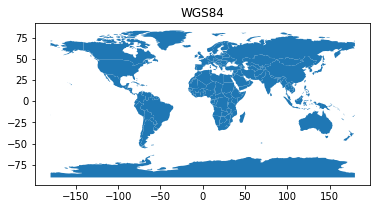

In [31]:
# Plot map in original crs:
admin.plot()

plt.title('WGS84')

Text(0.5, 1.0, 'Web Mercator')

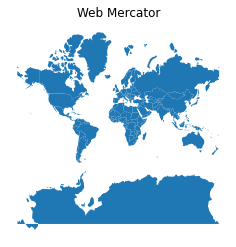

In [33]:
# Define projection as web mercator, 3785:
web_mercator = CRS.from_epsg(3785)

# Re-project and plot
admin.to_crs(web_mercator).plot()

# Remove x and y axis
plt.axis('off')
plt.title('Web Mercator')

Text(0.5, 1.0, 'Eckert IV')

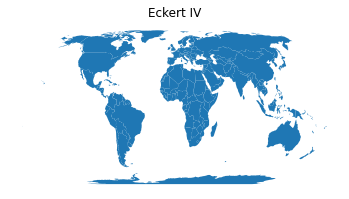

In [36]:
# Define projection Eckert IV from https://spatialreference.org/ref/esri/54012/
eckert_IV = CRS.from_proj4('+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs')

# Re-project and plot
admin.to_crs(eckert_IV).plot()

# Remove x and y axis
plt.axis('off')
plt.title('Eckert IV')

<AxesSubplot:>

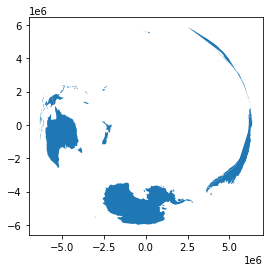

In [37]:
# Define an orthographic projection from: http://www.statsmapsnpix.com/2019/09/globe-projections-and-insets-in-qgis.html
# Make it centered around your hometown!

ortho = CRS.from_proj4('+proj=ortho +lat_0=-40.5333333333 +lon_0=-157.3333333339999 +x_0=0 +y_0=0 +a=6370997 +b=6370997 +units=m +no_defs')

# Re-project and plot
admin.to_crs(ortho).plot()

# Remove x and y axis



## Summary
That's it! In this section we learned how to:

1. reproject (transform) the geometries from crs to another using the `to_crs()` -function in GeoPandas
2. Define the coordinate reference system in different formats using `pyproj` `CRS`